In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
df = pd.read_csv('./archive/Clean_Dataset.csv', index_col = 0)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


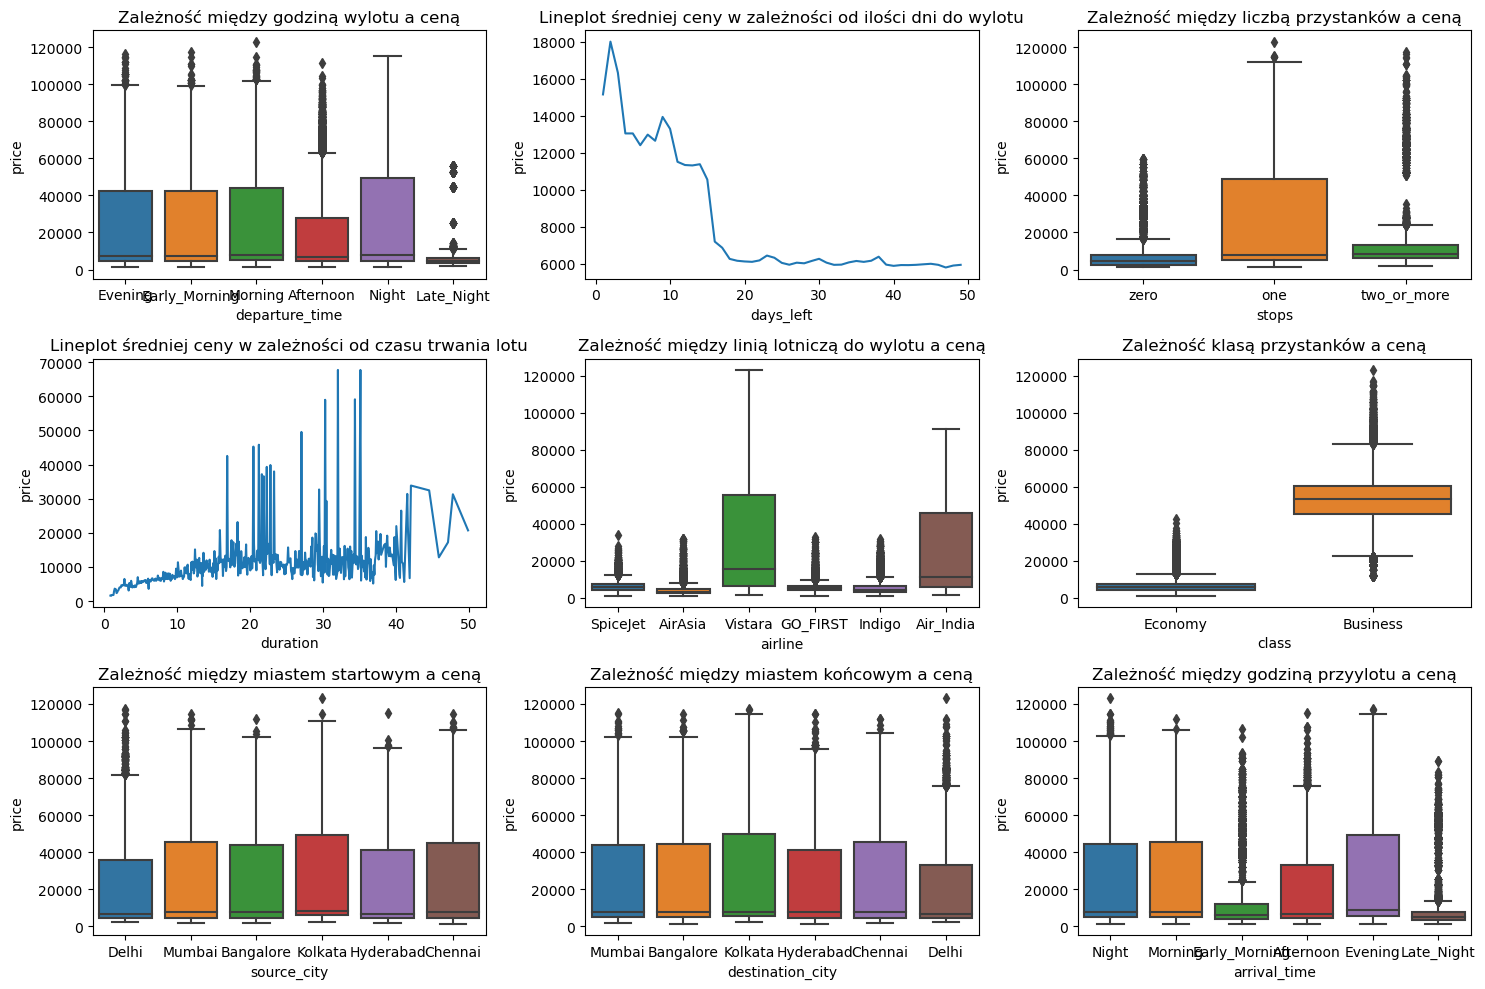

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df is your DataFrame
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10)) 

# Scatter plot for 'departure_time' vs 'price'
sns.boxplot(x='departure_time', y='price', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Zależność między godziną wylotu a ceną')

# Scatter plot for another variable vs 'price'
sns.lineplot(x='duration', y='price', data=df.groupby('duration')['price'].median().reset_index(), ax=axes[1, 0])
axes[1, 0].set_title('Lineplot średniej ceny w zależności od czasu trwania lotu')

# Scatter plot for another variable vs 'price'
sns.lineplot(x='days_left', y='price', data=df.groupby('days_left')['price'].median().reset_index(), ax=axes[0, 1])
axes[0, 1].set_title('Lineplot średniej ceny w zależności od ilości dni do wylotu')

sns.boxplot(x='airline', y='price', data=df, ax=axes[1,1])
axes[1, 1].set_title('Zależność między linią lotniczą do wylotu a ceną')

sns.boxplot(x='source_city', y='price', data=df, ax=axes[2, 0])
axes[2, 0].set_title('Zależność między miastem startowym a ceną')

sns.boxplot(x='destination_city', y='price', data=df, ax=axes[2, 1])
axes[2, 1].set_title('Zależność między miastem końcowym a ceną')

sns.boxplot(x = 'stops', y = 'price', data = df, ax = axes[0, 2])
axes[0, 2].set_title('Zależność między liczbą przystanków a ceną')

sns.boxplot(x = 'class', y = 'price', data = df, ax = axes[1, 2])
axes[1, 2].set_title('Zależność klasą przystanków a ceną')

sns.boxplot(x='arrival_time', y='price', data=df, ax=axes[2, 2])
axes[2, 2].set_title('Zależność między godziną przyylotu a ceną')



plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


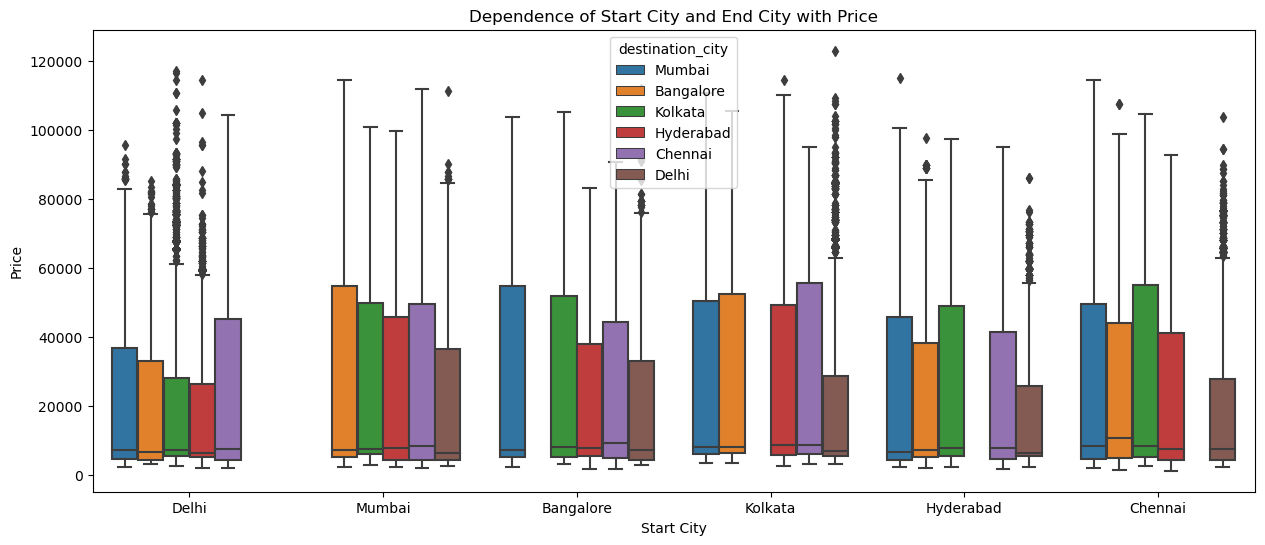

In [80]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='source_city', y='price', hue='destination_city', data=df)
plt.title('Dependence of Start City and End City with Price')
plt.xlabel('Start City')
plt.ylabel('Price')
plt.show()

In [84]:
df['airline'].astype('category')
df.dtypes

airline              object
flight               object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object

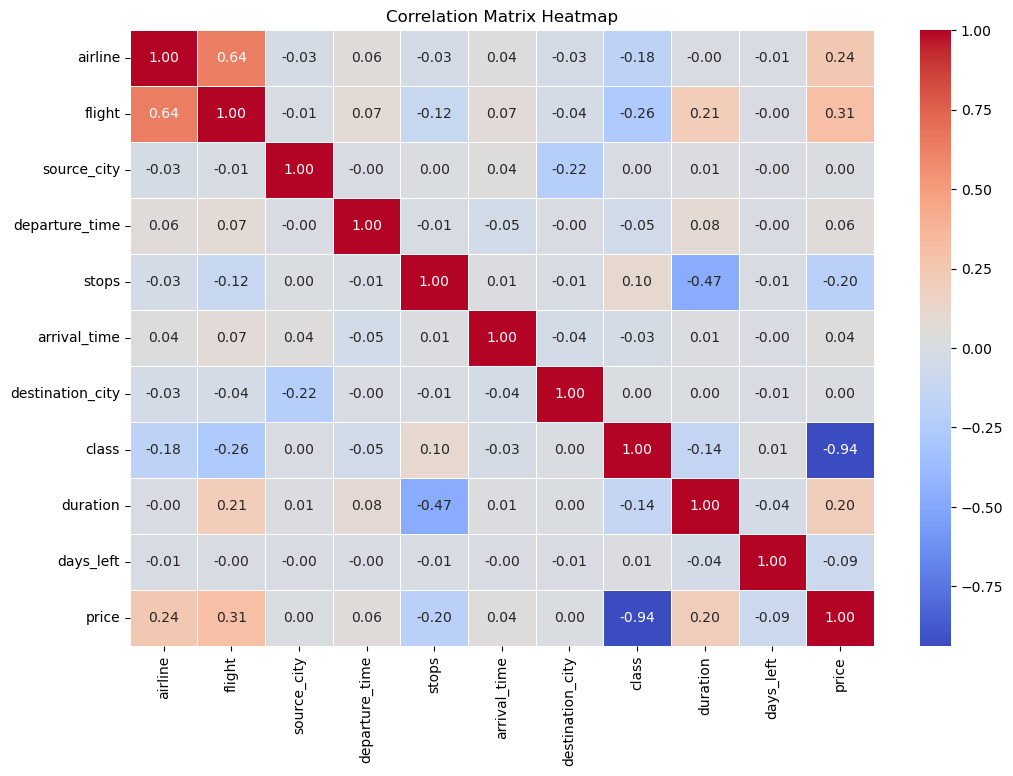

In [90]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
object_columns = ['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']

for column in object_columns:
    df[column] = label_encoder.fit_transform(df[column])

# Calculate the correlation matrix
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Looks like there is strong correlation between **Price** and **Class**. Other features don't affect price that much.

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

X = df.drop('price', axis=1)  # Features
y = df['price']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE with default parameters: {round(mse/1e6, 3)} mln')

MSE with default parameters: 8.84 mln


In [111]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [None,5, 7, 10, 13, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 12, 15, 17, 20, 25, 30]}
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_params

{'max_depth': None, 'min_samples_split': 20}

In [112]:
model2 = DecisionTreeRegressor(max_depth=best_params['max_depth'], min_samples_split = best_params['min_samples_split'])
model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE with selected parameters: {round(mse/1e6, 3)} mln')

MSE with selected parameters: 6.89 mln


In [113]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
from sklearn.decomposition import PCA

# Wybór liczby składowych, np. 2
n_components = 2

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)


X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
model_pca = DecisionTreeRegressor()
model_pca.fit(X_train_pca, y_train)
y_pred = model_pca.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE with PCA applied: {round(mse/1e6, 3)} mln')

MSE with PCA applied: 148.514 mln


### Feature Selection

In [116]:
X_reduced = df.drop(['source_city', 'destination_city', 'price'], axis = 1)
y = df['price'] 

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE with default parameters: {round(mse/1e6, 3)} mln')

MSE with default parameters: 12.241 mln


In [117]:
param_grid = {'max_depth': [None,5, 7, 10, 13, 15, 20, 25, 30, 35], 'min_samples_split': [2, 5, 10, 12, 15, 17, 20, 25, 30, 35]}
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_params

{'max_depth': 30, 'min_samples_split': 30}

In [120]:
model2 = DecisionTreeRegressor(max_depth=best_params['max_depth'], min_samples_split = best_params['min_samples_split'])
model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE with selected parameters: {round(mse/1e6, 3)} mln')

MSE with selected parameters: 8.818 mln


In [121]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
from sklearn.decomposition import PCA

# Wybór liczby składowych, np. 2
n_components = 2

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)


X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
model_pca = DecisionTreeRegressor()
model_pca.fit(X_train_pca, y_train)
y_pred = model_pca.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE with PCA applied: {round(mse/1e6, 3)} mln')

MSE with PCA applied: 149.142 mln


In [122]:
y_test

27131      7366
266857    64831
141228     6195
288329    60160
97334      6578
          ...  
5234       5026
5591       3001
168314     6734
175191     5082
287693    66465
Name: price, Length: 60031, dtype: int64

In [123]:
y_pred

array([ 4784., 67769.,  6195., ..., 32646.,  3393., 70049.])